My group wants to do its analysis on block groups within the City of Los Angeles. There is no geojson file that contains just this information, so I will have to import two separate files:
1) A geojson file that contains spatial information denoting spatial extent of the City of Los Angeles
2) A geojson file that contains block groups for the entire County of Los Angeles
I will then use these two files to create a new file with just the block groups within the City of Los Angeles.

In [1]:
import pandas as pd
import geopandas as gpd

First, I will import a dataset of census tracts associated with City of LA and inspect the data.

In [2]:
lacity=gpd.read_file('USDA_Food_Deserts.geojson')
lacity.head()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


,OBJECTID,CensusTract,State,POP2010_1,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,MedianFamilyIncome,TractHUNV,TractSNAP,SHAPE_Length,SHAPE_Area,geometry
0,1,6.037544e+09,California,Los Angeles,0,0,0,0,1.9,53,33,0.003390,5.066148e-09,"MULTIPOLYGON (((-118.22568 33.82705, -118.2256..."
1,2,6.037544e+09,California,Los Angeles,0,1,0,0,17.9,44,198,0.012832,7.920050e-08,"MULTIPOLYGON (((-118.26226 33.80462, -118.2622..."
2,3,6.037140e+09,California,Los Angeles,0,0,0,0,15.9,97,120,0.023402,2.842205e-05,"MULTIPOLYGON (((-118.51857 34.16243, -118.5220..."
3,4,6.037140e+09,California,Los Angeles,0,0,0,0,23.4,236,70,0.023957,3.434211e-05,"MULTIPOLYGON (((-118.52211 34.17109, -118.5220..."
4,5,6.037139e+09,California,Los Angeles,0,0,0,0,17.4,271,65,0.039510,8.857553e-05,"MULTIPOLYGON (((-118.53081 34.17143, -118.5308..."


Now, I will download a dataset of block groups within Los Angeles County and inspect the data.

In [3]:
countybgs=gpd.read_file('Census_Block_Groups_2020.geojson')
countybgs.head()

,OBJECTID,BG20,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry
0,1,1011101,101110,BG 1,4.814335e+06,8706.027651,"POLYGON ((-118.28497 34.25678, -118.28497 34.2..."
1,2,1011102,101110,BG 2,3.814445e+06,8807.809581,"POLYGON ((-118.29265 34.25957, -118.29319 34.2..."
2,3,1011103,101110,BG 3,3.666841e+06,8335.114480,"POLYGON ((-118.29134 34.25956, -118.29134 34.2..."
3,4,1011221,101122,BG 1,1.711345e+07,19507.471377,"POLYGON ((-118.29015 34.27417, -118.29015 34.2..."
4,5,1011222,101122,BG 2,1.134430e+07,19207.990424,"POLYGON ((-118.28528 34.26644, -118.28541 34.2..."


By plotting these two shapefiles, we can verify that they cover different geographies and use different spatial units. The "lacity" file countains the geographic extent that we are interested in, but the "countybgs" file contains that geographies that we're using as our unit as analysis.

<AxesSubplot: >

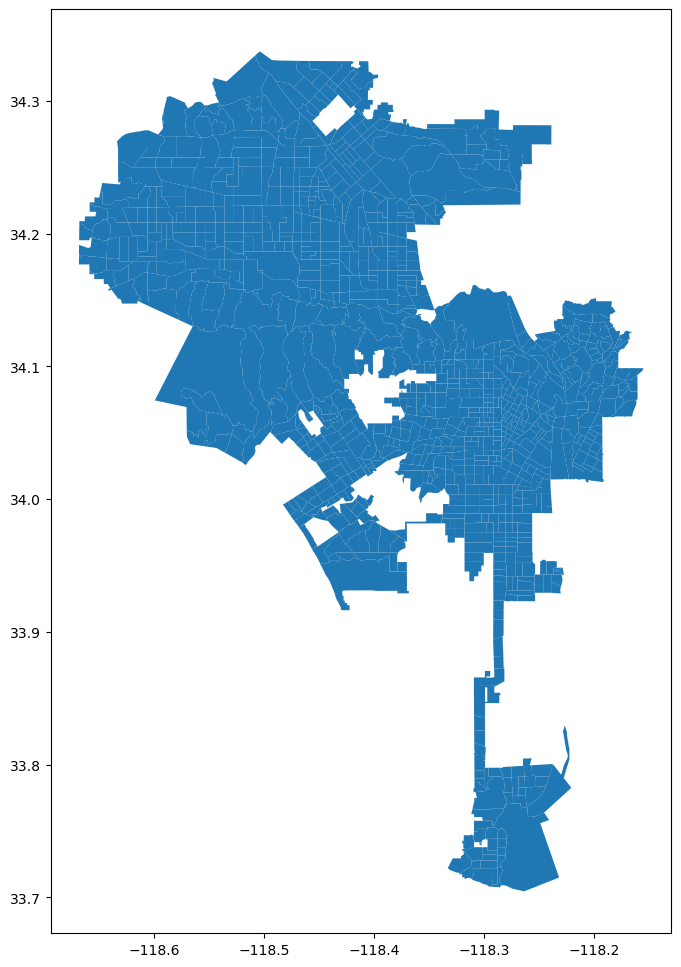

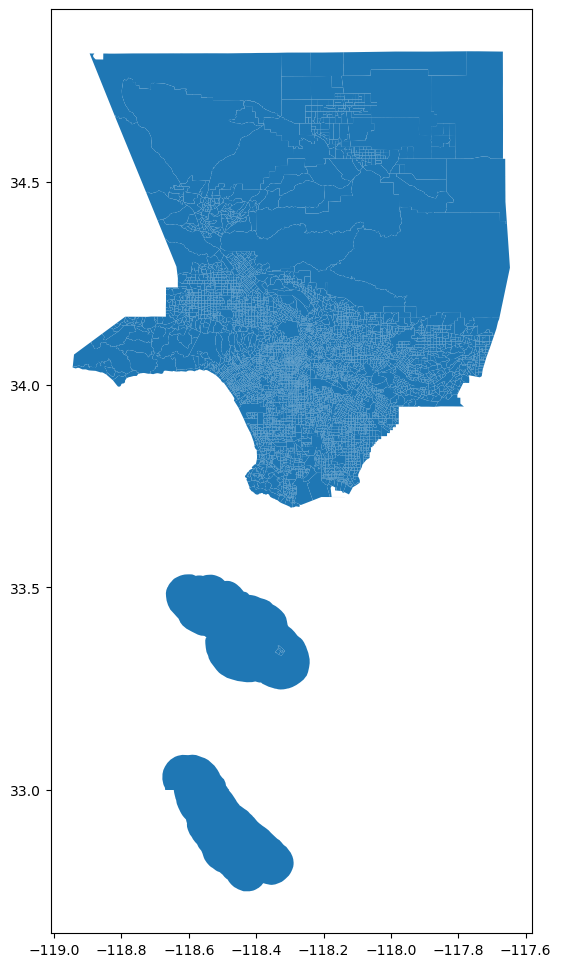

In [4]:
lacity.plot(figsize=(15,12))
countybgs.plot(figsize=(15,12))

To solve this problem, I "clipped" the countyblocks file to the lacity 'mask' following this documentation: https://geopandas.org/en/stable/docs/reference/api/geopandas.clip.html

In [5]:
citybgs = gpd.clip(countybgs, lacity)

/opt/conda/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Now if we plot the file, we'll see that cityblocks has block group units within just the City of Los Angeles. 

<AxesSubplot: >

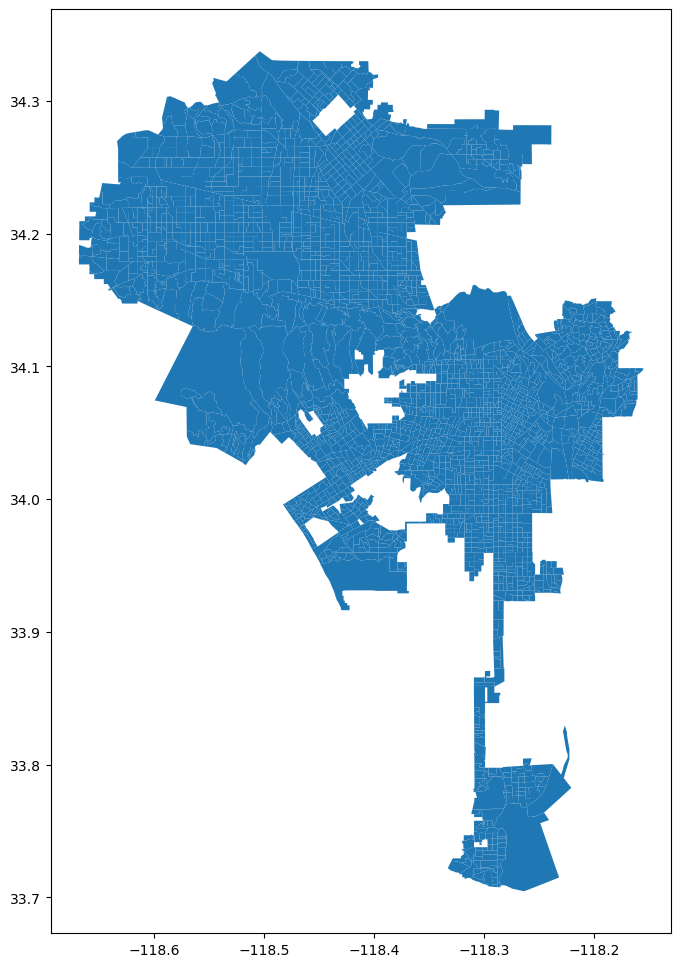

In [6]:
citybgs.plot(figsize=(15,12))

With the following inspection, we can find that there are 2,980 block groups in the City of Los Angeles. This is important, because we will use this information to "QA" future merges and ensure that no data has been lost.

In [7]:
citybgs.info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2980 entries, 2456 to 51
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   OBJECTID       2980 non-null   int64   
 1   BG20           2980 non-null   object  
 2   CT20           2980 non-null   object  
 3   LABEL          2980 non-null   object  
 4   ShapeSTArea    2980 non-null   float64 
 5   ShapeSTLength  2980 non-null   float64 
 6   geometry       2980 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 186.2+ KB


Now we are going to import our Census data from https://www.socialexplorer.com/tables/ACS2011_5yr/R13284518.
An important part of this step is specifying that the block group number (Geo_FIPS) is a string and not a number so that it can be used effectively in merges for analysis.

In [8]:
vehicles=pd.read_csv('R13284518_SL150.csv',    dtype=
    {
        'Geo_FIPS':str,
        'Geo_STATE':str,
        'Geo_COUNTY': str
    }
)

In [9]:
vehicles.head()

,Geo_FIPS,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,Geo_US,Geo_REGION,...,PCT_ACS11_5yr_B25045010,PCT_ACS11_5yr_B25045011,PCT_ACS11_5yr_B25045012,PCT_ACS11_5yr_B25045013,PCT_ACS11_5yr_B25045014,PCT_ACS11_5yr_B25045015,PCT_ACS11_5yr_B25045016,PCT_ACS11_5yr_B25045017,PCT_ACS11_5yr_B25045018,PCT_ACS11_5yr_B25045019
0,060371011101,"Block Group 1, Census Tract 1011.10, Los Angel...","Block Group 1, Census Tract 1011.10, Los Angel...",CA,150,0,ACSSF,27184,NaN,NaN,...,6.20,47.32,0.85,0.0,0.85,0.00,46.48,7.89,35.63,2.96
1,060371011102,"Block Group 2, Census Tract 1011.10, Los Angel...","Block Group 2, Census Tract 1011.10, Los Angel...",CA,150,0,ACSSF,27185,NaN,NaN,...,11.24,57.99,13.61,0.0,1.18,12.43,44.38,20.91,20.12,3.35
2,060371011103,"Block Group 3, Census Tract 1011.10, Los Angel...","Block Group 3, Census Tract 1011.10, Los Angel...",CA,150,0,ACSSF,27186,NaN,NaN,...,4.92,27.87,0.00,0.0,0.00,0.00,27.87,13.11,7.49,7.26
3,060371011221,"Block Group 1, Census Tract 1011.22, Los Angel...","Block Group 1, Census Tract 1011.22, Los Angel...",CA,150,0,ACSSF,27187,NaN,NaN,...,13.33,16.00,0.00,0.0,0.00,0.00,16.00,0.00,16.00,0.00
4,060371011222,"Block Group 2, Census Tract 1011.22, Los Angel...","Block Group 2, Census Tract 1011.22, Los Angel...",CA,150,0,ACSSF,27188,NaN,NaN,...,24.90,5.93,0.00,0.0,0.00,0.00,5.93,0.00,5.93,0.00


There are a ton of columns, so I'm going to create a new dataset with just the ones that I will need. 

In [10]:
vehicles_clean = vehicles[['Geo_FIPS','Geo_NAME','SE_A10030_001','SE_A10030_002','PCT_SE_A10030_002']].copy()
vehicles_clean

,Geo_FIPS,Geo_NAME,SE_A10030_001,SE_A10030_002,PCT_SE_A10030_002
0,060371011101,"Block Group 1, Census Tract 1011.10, Los Angel...",710,6,0.85
1,060371011102,"Block Group 2, Census Tract 1011.10, Los Angel...",507,69,13.61
2,060371011103,"Block Group 3, Census Tract 1011.10, Los Angel...",427,0,0.00
3,060371011221,"Block Group 1, Census Tract 1011.22, Los Angel...",750,7,0.93
4,060371011222,"Block Group 2, Census Tract 1011.22, Los Angel...",506,0,0.00
...,...,...,...,...,...
6420,060379800311,"Block Group 1, Census Tract 9800.31, Los Angel...",45,0,0.00
6421,060379800331,"Block Group 1, Census Tract 9800.33, Los Angel...",0,0,NaN
6422,060379901000,"Block Group 0, Census Tract 9901, Los Angeles ...",0,0,NaN
6423,060379902000,"Block Group 0, Census Tract 9902, Los Angeles ...",0,0,NaN


Next I will rename the column names so that they're easier to use.

In [11]:
vehicles_clean.columns = ['FIPS_2010', 'Geography_Name', 'Number_HHs', 'Num_ZeroCarHHs', 'Pct_ZeroCarHHs']
vehicles_clean.head()

,FIPS_2010,Geography_Name,Number_HHs,Num_ZeroCarHHs,Pct_ZeroCarHHs
0,060371011101,"Block Group 1, Census Tract 1011.10, Los Angel...",710,6,0.85
1,060371011102,"Block Group 2, Census Tract 1011.10, Los Angel...",507,69,13.61
2,060371011103,"Block Group 3, Census Tract 1011.10, Los Angel...",427,0,0.00
3,060371011221,"Block Group 1, Census Tract 1011.22, Los Angel...",750,7,0.93
4,060371011222,"Block Group 2, Census Tract 1011.22, Los Angel...",506,0,0.00


I have learned (the hard way) that block group numbers changed substantially from 2010 to 2020, so the next step is to download a crosswalk and find the 2020 block group IDS for this dataset.

In [12]:
crosswalk=pd.read_csv('nhgis_bg2010_co2020_06.csv',    dtype=
    {
        'bg2010ge':str,
        'bg2020ge':str,
    }
)
crosswalk

,bg2010gj,bg2010ge,co2020gj,co2020ge,wt_pop,wt_adult,wt_hh,wt_fam,wt_hu,parea
0,G06000104001001,060014001001,G0600010,6001,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.996875
1,G06000104001001,060014001001,G0600130,6013,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.003125
2,G06000104002001,060014002001,G0600010,6001,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
3,G06000104002002,060014002002,G0600010,6001,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
4,G06000104003001,060014003001,G0600010,6001,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
...,...,...,...,...,...,...,...,...,...,...
23343,G41003509705002,410359705002,G0600490,6049,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.045183e-06,0.000276
23344,G41003509706001,410359706001,G0600490,6049,8.764700e-08,1.208720e-07,1.501990e-07,1.332730e-07,1.806880e-07,0.000002
23345,G41003509706001,410359706001,G0600930,6093,7.597759e-04,4.373102e-04,4.329926e-04,5.762998e-04,4.501363e-04,0.001237
23346,G41003509707001,410359707001,G0600930,6093,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000065


I just need a single column for the 2010 and 2020 block group IDs and will rename them to be more easily usable.

In [42]:
crosswalk_clean = crosswalk[['bg2010ge','bg2020ge']].copy()
crosswalk_clean.columns = ['FIPS_2010', 'FIPS_2020']
crosswalk_clean

,FIPS_2020,FIPS_2010
0,060014001001,060014001001
1,060014001001,060133540011
2,060014001001,060014226001
3,060014001001,060014216001
4,060014001001,060014227001
...,...,...
33318,410359706001,060490002001
33319,410359706001,060930001001
33320,410359707001,060930002001
33321,410379601001,060490004001


In [43]:
vehicles_crosswalked=vehicles_clean.merge(crosswalk_clean,on="FIPS_2010")
vehicles_crosswalked

,FIPS_2010,Geography_Name,Number_HHs,Num_ZeroCarHHs,Pct_ZeroCarHHs,FIPS_2020
0,060371011101,"Block Group 1, Census Tract 1011.10, Los Angel...",710,6,0.85,060371011101
1,060371011102,"Block Group 2, Census Tract 1011.10, Los Angel...",507,69,13.61,060371011102
2,060371011103,"Block Group 3, Census Tract 1011.10, Los Angel...",427,0,0.00,060371011103
3,060371011221,"Block Group 1, Census Tract 1011.22, Los Angel...",750,7,0.93,060371011221
4,060371011222,"Block Group 2, Census Tract 1011.22, Los Angel...",506,0,0.00,060371011222
...,...,...,...,...,...,...
8123,060379903000,"Block Group 0, Census Tract 9903, Los Angeles ...",0,0,NaN,060375773001
8124,060379903000,"Block Group 0, Census Tract 9903, Los Angeles ...",0,0,NaN,060375775041
8125,060379903000,"Block Group 0, Census Tract 9903, Los Angeles ...",0,0,NaN,060379800311
8126,060379903000,"Block Group 0, Census Tract 9903, Los Angeles ...",0,0,NaN,060379903000


Now, I will merge this data with the spatial dataset from earlier!
The first step to this is adding in a FIPS column to the geojson from earlier. 

In [49]:
citybgs['FIPS_2020'] ='06' + '037' + citybgs['BG20']
citybgs

,OBJECTID,BG20,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,FIPS,FIPS_2020
2456,2457,2742023,274202,BG 3,1.045276e+06,4082.112116,"POLYGON ((-118.46565 33.97974, -118.46527 33.9...",060372742023,060372742023
2449,2450,2739025,273902,BG 5,5.131686e+06,9166.983856,"MULTIPOLYGON (((-118.46685 33.97905, -118.4678...",060372739025,060372739025
2448,2449,2739024,273902,BG 4,1.861628e+06,6284.133027,"MULTIPOLYGON (((-118.46415 33.98063, -118.4642...",060372739024,060372739024
2447,2448,2739023,273902,BG 3,1.218168e+06,4851.582209,"POLYGON ((-118.46315 33.98615, -118.46310 33.9...",060372739023,060372739023
2435,2436,2735023,273502,BG 3,4.868382e+06,10124.770714,"POLYGON ((-118.47506 33.98846, -118.47468 33.9...",060372735023,060372735023
...,...,...,...,...,...,...,...,...,...
34,35,1033001,103300,BG 1,3.089421e+07,24776.878065,"POLYGON ((-118.37255 34.25866, -118.37241 34.2...",060371033001,060371033001
6572,6573,9800211,980021,BG 1,7.475771e+07,51403.146970,"MULTIPOLYGON (((-118.37712 34.27423, -118.3765...",060379800211,060379800211
50,51,1041242,104124,BG 2,1.099876e+07,16854.994635,"POLYGON ((-118.37089 34.28614, -118.37057 34.2...",060371041242,060371041242
42,43,1041032,104103,BG 2,5.477766e+06,10840.273595,"MULTIPOLYGON (((-118.38342 34.28375, -118.3838...",060371041032,060371041032


There are now two equivalent FIPS columns that can be used in a merge.

In [50]:
vehicles_bgs=citybgs.merge(vehicles_crosswalked,on="FIPS_2020")
vehicles_bgs

,OBJECTID,BG20,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,FIPS,FIPS_2020,FIPS_2010,Geography_Name,Number_HHs,Num_ZeroCarHHs,Pct_ZeroCarHHs
0,2457,2742023,274202,BG 3,1.045276e+06,4082.112116,"POLYGON ((-118.46565 33.97974, -118.46527 33.9...",060372742023,060372742023,060372742024,"Block Group 4, Census Tract 2742.02, Los Angel...",323,0,0.00
1,2450,2739025,273902,BG 5,5.131686e+06,9166.983856,"MULTIPOLYGON (((-118.46685 33.97905, -118.4678...",060372739025,060372739025,060372739023,"Block Group 3, Census Tract 2739.02, Los Angel...",547,15,2.74
2,2449,2739024,273902,BG 4,1.861628e+06,6284.133027,"MULTIPOLYGON (((-118.46415 33.98063, -118.4642...",060372739024,060372739024,060372739022,"Block Group 2, Census Tract 2739.02, Los Angel...",437,37,8.47
3,2449,2739024,273902,BG 4,1.861628e+06,6284.133027,"MULTIPOLYGON (((-118.46415 33.98063, -118.4642...",060372739024,060372739024,060372739025,"Block Group 5, Census Tract 2739.02, Los Angel...",195,13,6.67
4,2448,2739023,273902,BG 3,1.218168e+06,4851.582209,"POLYGON ((-118.46315 33.98615, -118.46310 33.9...",060372739023,060372739023,060372739024,"Block Group 4, Census Tract 2739.02, Los Angel...",613,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3374,35,1033001,103300,BG 1,3.089421e+07,24776.878065,"POLYGON ((-118.37255 34.25866, -118.37241 34.2...",060371033001,060371033001,060371033001,"Block Group 1, Census Tract 1033, Los Angeles ...",604,7,1.16
3375,6573,9800211,980021,BG 1,7.475771e+07,51403.146970,"MULTIPOLYGON (((-118.37712 34.27423, -118.3765...",060379800211,060379800211,060379800211,"Block Group 1, Census Tract 9800.21, Los Angel...",0,0,NaN
3376,51,1041242,104124,BG 2,1.099876e+07,16854.994635,"POLYGON ((-118.37089 34.28614, -118.37057 34.2...",060371041242,060371041242,060371041242,"Block Group 2, Census Tract 1041.24, Los Angel...",522,0,0.00
3377,43,1041032,104103,BG 2,5.477766e+06,10840.273595,"MULTIPOLYGON (((-118.38342 34.28375, -118.3838...",060371041032,060371041032,060371041032,"Block Group 2, Census Tract 1041.03, Los Angel...",338,8,2.37


From the following, we can get some basic stats about the number of zero-vehicle households in block groups in the City of LA:

In [51]:
vehicles_bgs['Num_ZeroCarHHs'].describe()

count    3379.000000
mean       68.447174
std        89.281318
min         0.000000
25%        12.000000
50%        41.000000
75%        91.500000
max       893.000000
Name: Num_ZeroCarHHs, dtype: float64

<AxesSubplot: ylabel='Frequency'>

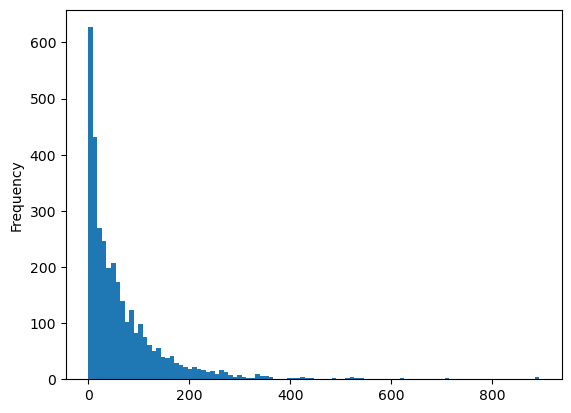

In [52]:
vehicles_bgs['Num_ZeroCarHHs'].plot.hist(bins=100)

In [53]:
vehicles_bgs['Pct_ZeroCarHHs'].describe()

count    3356.000000
mean       11.961833
std        12.401447
min         0.000000
25%         2.760000
50%         8.255000
75%        17.615000
max        89.810000
Name: Pct_ZeroCarHHs, dtype: float64

<AxesSubplot: ylabel='Frequency'>

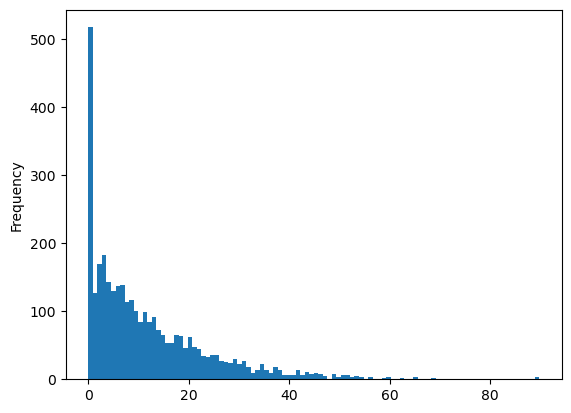

In [54]:
vehicles_bgs['Pct_ZeroCarHHs'].plot.hist(bins=100)

An initial exploratory map

<AxesSubplot: >

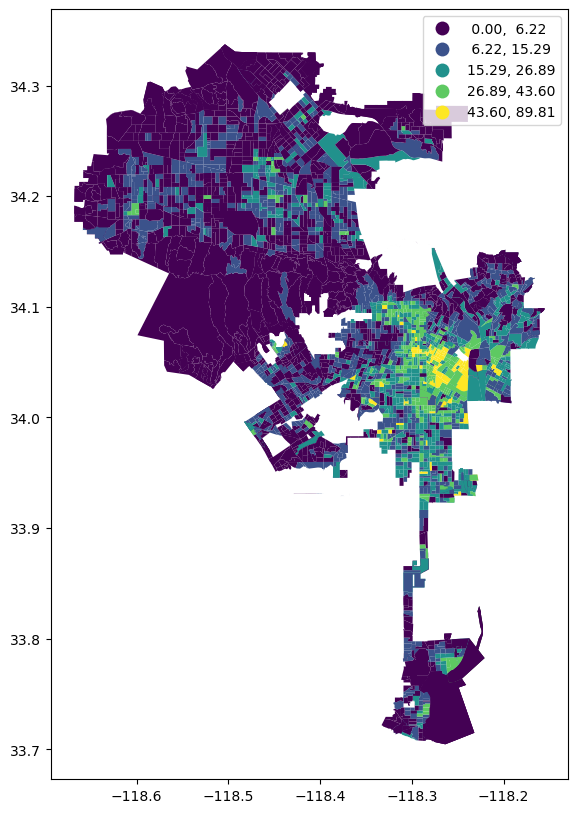

In [55]:
vehicles_bgs.plot(figsize=(12,10),
                 column='Pct_ZeroCarHHs',
                 legend=True, 
                 scheme='NaturalBreaks')

Something is wrong :( I know that I've somehow lost ~500 block groups along the way and will have to figure out what happened.

<AxesSubplot: >

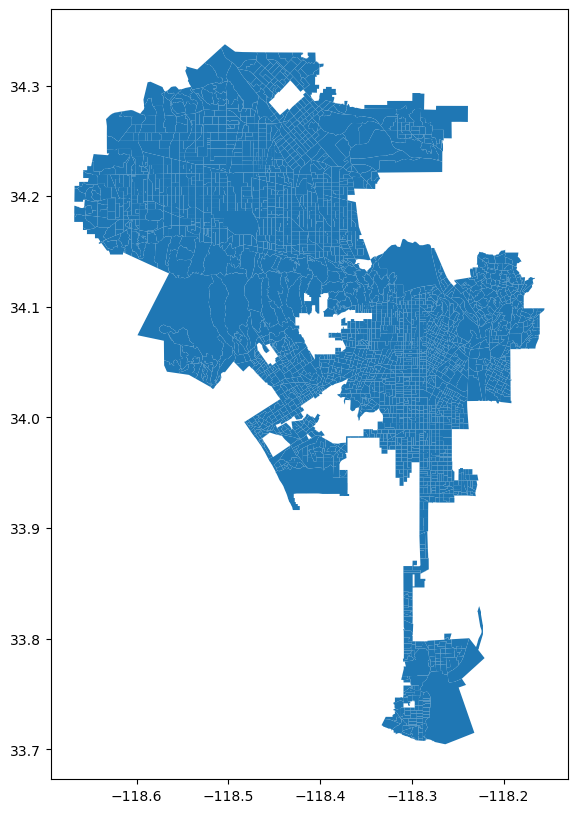

In [34]:
citybgs.plot(figsize=(12,10))

In [37]:
citybgs[citybgs.FIPS == '060372643052']

,OBJECTID,BG20,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,FIPS
2236,2237,2643052,264305,BG 2,1.126576e+07,16397.658261,"POLYGON ((-118.49174 34.04832, -118.49164 34.0...",060372643052


In [36]:
vehicles_clean[vehicles_clean.FIPS == '060372643052']

,FIPS,Geography_Name,Number_HHs,Num_ZeroCarHHs,Pct_ZeroCarHHs


In [38]:
vehicles_bgs[vehicles_bgs.FIPS == '060372643052']

,OBJECTID,BG20,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,FIPS,Geography_Name,Number_HHs,Num_ZeroCarHHs,Pct_ZeroCarHHs
